In [141]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import random
import warnings
import os

from tqdm import tqdm
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

In [142]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")


In [143]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [144]:
seedEverything(1)



In [145]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [146]:
class BaselineMNISTNetwork(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=(5, 5), stride=1
        )

        self.ReLU = nn.ReLU()

        self.flatten = nn.Flatten()

        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=(5, 5), stride=1
        )

        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=512, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool1(self.ReLU(self.conv1(x)))
        x = self.pool2(self.ReLU(self.conv2(x)))
        x = self.flatten(x)
        x = self.ReLU(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

## Фиксируем необходимые гиперпараметры

In [147]:
batch_size = 32
learning_rate = 0.01
epochs = 10
num_classes = 10

## Загружаем набор данных для обучения MNIST

In [148]:
traindataset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)

testdataset = torchvision.datasets. MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True)

## Определяем модель, функцию потерь и оптимизатор

In [149]:
criterion = nn.CrossEntropyLoss()
model = BaselineMNISTNetwork(num_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Метрика качества

In [150]:
metric_func = accuracy_score

## Процесс обучения модели

In [151]:
def train(model, trainloader, testloader, epochs, optimizer, criterion, metric_func):

  model.train()

  bar = tqdm(total=epochs, ncols=120)
  for epoch in range(epochs):

    train_acc = 0
    test_acc = 0
    train_loss = 0

    for (batch_idx, train_batch) in enumerate(trainloader):
      images, label = train_batch[0].to(device), train_batch[1].to(device)
      logits = model(images)
      preds = logits.argmax(dim=1)
      loss = criterion(logits, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_acc += metric_func(preds.cpu().numpy(), label.cpu().numpy())

    train_acc = train_acc / len(trainloader)
    train_loss = train_loss / len(trainloader)

    model.eval()

    with torch.no_grad():
      for test_batch in testloader:
        images, label = test_batch[0].to(device), test_batch[1].to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        test_acc += metric_func(preds.cpu().numpy(), label.cpu().numpy())

    test_acc = test_acc / len(testloader)

    model.train()

    bar.set_description(f"|EPOCH: {epoch+1}|TRAIN_LOSS: {round(train_loss, 3)}|TRAIN_ACC: {round(train_acc, 3)}|TEST_ACC: {round(test_acc, 3)}")
    bar.update()

  return model

## Запускаем процесс обучения модели

In [152]:
model = train(model, trainloader, testloader, epochs, optimizer, criterion, metric_func)

|EPOCH: 10|TRAIN_LOSS: 1.472|TRAIN_ACC: 0.99|TEST_ACC: 0.988: 100%|█████████████████████| 10/10 [02:31<00:00, 15.15s/it]


## Задание

* Попробуйте реализовать backdoor-атаку, описанную в статье в главе **4. Case Study: MNIST Digit Recognition Attack**.
* В качестве триггера, внедряемого в изображение, предлагается использовать представленный в статье вариант.
* Возможно, вам захочется придумать свой собственный триггер (пример изображен на рисунке ниже).
* Подумайте, каким образом можно сделать используемый триггер более незаметным.
* Для выбора целевой метки можно воспользоваться механизмом, представленным в статье, или выбрать свою собственную из 10 представленных классов (помните, что целевая метка не должна совпадать с истинной меткой для заражённых изображений в наборе данных).
* В качестве модели сверточной нейронной сети используйте модель, реализованную ниже.
* Набор данных на данном этапе уже загружен (**traindataset**, **testdataset**). Посмотрите, что находится внутри данных наборов данных, и как можно получить изображения с метками классов. Далее внедрите выбранный вами триггер в отобранные из **traindataset** изображения, измените метки классов данных изображений на целевую и верните изменённые изображения в **traindataset**.
* Запустите обучение модели на заражённом **traindataset**.
* После обучения проверьте работоспособность атаки.

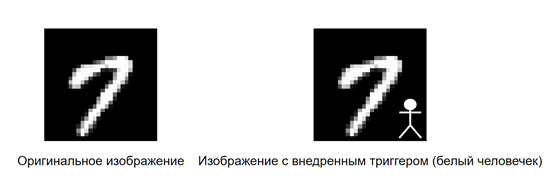

In [153]:
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

Размер картинки:torch.Size([1, 28, 28])


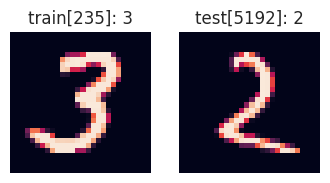

In [154]:
# берем 2 рандомных индекса
train_idx, test_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{traindataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(traindataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[traindataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(testdataset[test_idx][0].permute(1, 2, 0))
plt.title(f"test[{test_idx}]: {classes[testdataset[test_idx][1]]}")
plt.axis("off");

In [156]:
from torch.utils.data import Dataset, DataLoader

In [295]:
class BackdoorMNISTDataset(Dataset):
    def __init__(self, original_dataset, backdoor_percentage, target_label=7):
        self.original_dataset = original_dataset
        self.backdoor_percentage = backdoor_percentage
        self.target_label = target_label
        self.backdoor_indices = np.random.choice(
            len(self.original_dataset),
            size=int(len(self.original_dataset)*  self.backdoor_percentage),
            replace=False,
        )

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        image, label = self.original_dataset[index]

        if index in self.backdoor_indices:
            # Изменение метки на целевую
            label = self.target_label
            # Внедрение backdoor
            image[0, 0] = 1.0 

        return image, label

    def get_backdoor_images(self):
        """Возвращает список зараженных картинок с индексом."""
        backdoor_images = []
        for i in self.backdoor_indices:
            image, label = self.original_dataset[i]
            backdoor_images.append((image, label, i)) 
        return backdoor_images

In [296]:
backdoor_image, backdoor_label, index = backdoor_dataset.get_backdoor_images()[0]


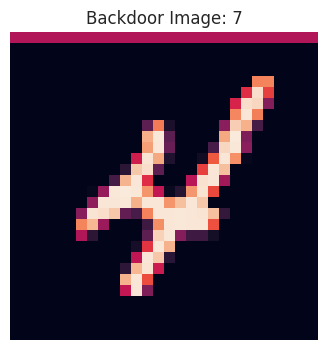

In [311]:
for i in range(len(backdoor_dataset)):
  image, label = backdoor_dataset[i]
  if label == 7: # Если метка 7, это зараженная картинка
    backdoor_index = i
    break

# Визуализируйте зараженную картинку
plt.figure(figsize=(4, 4))
plt.imshow(backdoor_dataset[backdoor_index][0].permute(1, 2, 0))
plt.title(f"Backdoor Image: {backdoor_dataset[backdoor_index][1]}")
plt.axis('off')
plt.show()

In [324]:
for i in range(len(backdoor_dataset)):
  image, label = backdoor_dataset[i]
  if label == 7: # Если метка 7, это зараженная картинка
    backdoor_index = i
    print(i)



9
14
15
23
29
34
37
38
40
42
52
61
66
71
79
84
86
90
91
96
99
101
102
103
108
113
116
118
123
126
129
138
140
141
143
148
158
168
173
182
185
188
190
193
196
198
208
212
214
223
230
243
258
263
281
288
301
305
307
324
331
337
340
349
353
359
367
370
371
377
380
384
387
389
392
407
411
422
426
433
436
446
459
461
467
468
478
483
489
497
504
505
511
515
518
519
521
522
535
540
550
556
560
562
567
572
576
579
586
593
596
599
601
608
610
611
614
617
624
632
634
635
636
640
644
647
651
654
657
671
673
678
683
686
701
703
723
724
727
728
730
750
753
754
756
768
773
782
786
789
790
795
798
803
806
819
820
821
824
829
835
838
839
844
853
868
880
883
884
888
898
902
904
908
909
911
918
928
932
933
934
935
936
942
948
950
952
954
962
968
969
971
981
994
995
999
1001
1004
1014
1019
1022
1023
1042
1043
1044
1054
1057
1061
1065
1072
1075
1082
1088
1089
1091
1093
1094
1106
1107
1110
1114
1125
1126
1127
1128
1131
1137
1153
1154
1156
1157
1159
1166
1181
1186
1191
1192
1205
1208
1210
1216
1217
1225
122

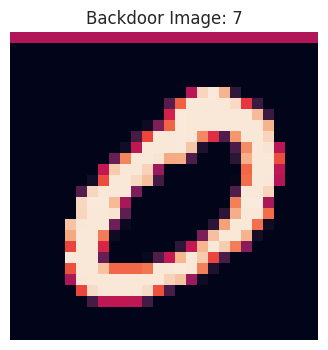

In [329]:
# Визуализируйте зараженную картинку
plt.figure(figsize=(4, 4))
plt.imshow(backdoor_dataset[5627][0].permute(1, 2, 0))
plt.title(f"Backdoor Image: {backdoor_dataset[5627][1]}")
plt.axis('off')
plt.show()

Размер картинки:torch.Size([1, 28, 28])


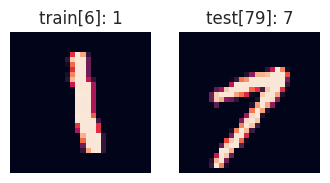

In [330]:
# берем 2 рандомных индекса
train_idx, test_idx = np.random.randint(0, 100, 2)
print(f"Размер картинки:{backdoor_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(backdoor_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[backdoor_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(backdoor_dataset[test_idx][0].permute(1, 2, 0))
plt.title(f"test[{test_idx}]: {classes[backdoor_dataset[test_idx][1]]}")
plt.axis("off");

|EPOCH: 10|TRAIN_LOSS: 1.472|TRAIN_ACC: 0.989|TEST_ACC: 0.992: 100%|████████████████████| 10/10 [03:09<00:00, 18.94s/it]
|EPOCH: 10|TRAIN_LOSS: 1.48|TRAIN_ACC: 0.981|TEST_ACC: 0.992: 100%|█████████████████████| 10/10 [03:21<00:00, 20.15s/it]
|EPOCH: 10|TRAIN_LOSS: 1.552|TRAIN_ACC: 0.909|TEST_ACC: 0.992: 100%|████████████████████| 10/10 [03:26<00:00, 20.63s/it]
|EPOCH: 10|TRAIN_LOSS: 1.642|TRAIN_ACC: 0.82|TEST_ACC: 0.991: 100%|█████████████████████| 10/10 [03:32<00:00, 21.25s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


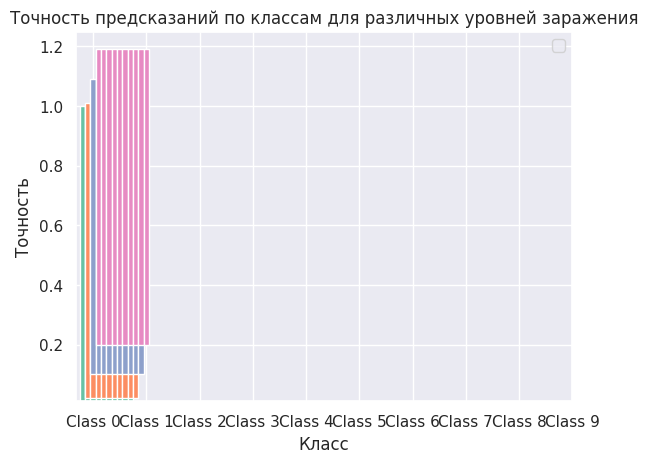

In [315]:
poison_rates = [0.01, 0.02, 0.1, 0.2]  # Проценты заражения (1%, 2%, 10%, 20%)
class_accuracies = []

for poison_rate in poison_rates:
    # Заражение данных
    poisoned_train_dataset = BackdoorMNISTDataset(traindataset, poison_rate)
    # Целевая метка: 7 (цифра 7)
    poisoned_train_loader = DataLoader(
        poisoned_train_dataset, batch_size, shuffle=True
    )
    train(model, poisoned_train_loader, testloader, epochs, optimizer, criterion, metric_func)

    # Вычисление точности по классам
    class_accuracy = []
    with torch.no_grad():
        for i in range(10):  # 10 классов (цифры от 0 до 9)
            correct = 0
            total = 0
            for images, labels in testloader:
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            class_accuracy.append(correct / total)
    class_accuracies.append(class_accuracy)



In [322]:
#0.01, 0.02, 0.1, 0.2
import pandas as pd
# Создаем таблицу с использованием Pandas
df = pd.DataFrame(class_accuracies, columns=[f'Класс {i}' for i in range(10)])

# Добавляем столбец с описанием степени заражения
df['Степень заражения'] = [f'Степень {i+1}' for i in range(len(class_accuracies))]

# Выводим таблицу
print(df)


   Класс 0  Класс 1  Класс 2  Класс 3  Класс 4  Класс 5  Класс 6  Класс 7  \
0   0.9916   0.9916   0.9916   0.9916   0.9916   0.9916   0.9916   0.9916   
1   0.9920   0.9920   0.9920   0.9920   0.9920   0.9920   0.9920   0.9920   
2   0.9918   0.9918   0.9918   0.9918   0.9918   0.9918   0.9918   0.9918   
3   0.9907   0.9907   0.9907   0.9907   0.9907   0.9907   0.9907   0.9907   

   Класс 8  Класс 9 Степень заражения  
0   0.9916   0.9916         Степень 1  
1   0.9920   0.9920         Степень 2  
2   0.9918   0.9918         Степень 3  
3   0.9907   0.9907         Степень 4  


In [246]:
poison_rates = [0.01, 0.02, 0.1, 0.2]  # Проценты заражения (1%, 2%, 10%, 20%)

for poison_rate in poison_rates:
    # Заражение данных
    poisoned_train_dataset=BackdoorMNISTDataset(traindataset, poison_rate)
      # Целевая метка: 7 (цифра 7)
    poisoned_train_loader = DataLoader(
        poisoned_train_dataset, batch_size, shuffle=True
    )
    train(model, poisoned_train_loader, testloader, epochs, optimizer, criterion, metric_func)



  0%|                                                                                            | 0/10 [00:00<?, ?it/s]
|EPOCH: 1|TRAIN_LOSS: 1.48|TRAIN_ACC: 0.982|TEST_ACC: 0.988:   0%|                               | 0/10 [00:15<?, ?it/s]
|EPOCH: 1|TRAIN_LOSS: 1.48|TRAIN_ACC: 0.982|TEST_ACC: 0.988:  10%|██▎                    | 1/10 [00:15<02:23, 15.96s/it]
|EPOCH: 2|TRAIN_LOSS: 1.48|TRAIN_ACC: 0.982|TEST_ACC: 0.991:  10%|██▎                    | 1/10 [00:31<02:23, 15.96s/it]
|EPOCH: 2|TRAIN_LOSS: 1.48|TRAIN_ACC: 0.982|TEST_ACC: 0.991:  20%|████▌                  | 2/10 [00:31<02:07, 15.92s/it]
|EPOCH: 3|TRAIN_LOSS: 1.479|TRAIN_ACC: 0.983|TEST_ACC: 0.99:  20%|████▌                  | 2/10 [00:48<02:07, 15.92s/it]
|EPOCH: 3|TRAIN_LOSS: 1.479|TRAIN_ACC: 0.983|TEST_ACC: 0.99:  30%|██████▉                | 3/10 [00:48<01:54, 16.35s/it]
|EPOCH: 4|TRAIN_LOSS: 1.478|TRAIN_ACC: 0.984|TEST_ACC: 0.989:  30%|██████▌               | 3/10 [01:10<01:54, 16.35s/it]
|EPOCH: 4|TRAIN_LOSS: 1.478|TRA

Получилось как в статье, теперь рассмотрим другие триггеры, например, квадратик, можно сделать его менее заметным за счет яркости

In [331]:
def inject_backdoor(data, target_class, poison_rate, pattern):
    poisoned_data = []
    for i, (image, label) in enumerate(data):
        if np.random.rand() < poison_rate:
            # Внедрение триггера (паттерн)
            image[pattern[0]:pattern[0]+pattern[2], pattern[1]:pattern[1]+pattern[3]] = pattern[4]
            label = target_class  # Изменение метки на целевую
        poisoned_data.append((image, label))
    return poisoned_data


In [332]:
poison_rates = [0.01, 0.02, 0.1, 0.2]  # Проценты заражения (1%, 2%, 10%, 20%)
class_accuracies = []

for poison_rate in poison_rates:
    # Заражение данных
    poisoned_train_dataset = inject_backdoor(traindataset, target_class=7, poison_rate=0.1, pattern = [10, 10, 5, 5, 1.0] )
    poisoned_train_loader = DataLoader(
        poisoned_train_dataset, batch_size, shuffle=True
    )
    train(model, poisoned_train_loader, testloader, epochs, optimizer, criterion, metric_func)

    # Вычисление точности по классам
    class_accuracy = []
    with torch.no_grad():
        for i in range(10):  # 10 классов (цифры от 0 до 9)
            correct = 0
            total = 0
            for images, labels in testloader:
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            class_accuracy.append(correct / total)
    class_accuracies.append(class_accuracy)


|EPOCH: 10|TRAIN_LOSS: 1.552|TRAIN_ACC: 0.91|TEST_ACC: 0.992: 100%|█████████████████████| 10/10 [01:56<00:00, 11.64s/it]
|EPOCH: 10|TRAIN_LOSS: 1.553|TRAIN_ACC: 0.909|TEST_ACC: 0.992: 100%|████████████████████| 10/10 [02:11<00:00, 13.13s/it]
|EPOCH: 10|TRAIN_LOSS: 1.553|TRAIN_ACC: 0.908|TEST_ACC: 0.992: 100%|████████████████████| 10/10 [02:05<00:00, 12.54s/it]
|EPOCH: 10|TRAIN_LOSS: 1.553|TRAIN_ACC: 0.908|TEST_ACC: 0.992: 100%|████████████████████| 10/10 [02:10<00:00, 13.09s/it]


In [333]:
#0.01, 0.02, 0.1, 0.2
import pandas as pd
# Создаем таблицу с использованием Pandas
df = pd.DataFrame(class_accuracies, columns=[f'Класс {i}' for i in range(10)])

# Добавляем столбец с описанием степени заражения
df['Степень заражения'] = [f'Степень {i+1}' for i in range(len(class_accuracies))]

# Выводим таблицу
print(df)


   Класс 0  Класс 1  Класс 2  Класс 3  Класс 4  Класс 5  Класс 6  Класс 7  \
0   0.9920   0.9920   0.9920   0.9920   0.9920   0.9920   0.9920   0.9920   
1   0.9925   0.9925   0.9925   0.9925   0.9925   0.9925   0.9925   0.9925   
2   0.9915   0.9915   0.9915   0.9915   0.9915   0.9915   0.9915   0.9915   
3   0.9919   0.9919   0.9919   0.9919   0.9919   0.9919   0.9919   0.9919   

   Класс 8  Класс 9 Степень заражения  
0   0.9920   0.9920         Степень 1  
1   0.9925   0.9925         Степень 2  
2   0.9915   0.9915         Степень 3  
3   0.9919   0.9919         Степень 4  


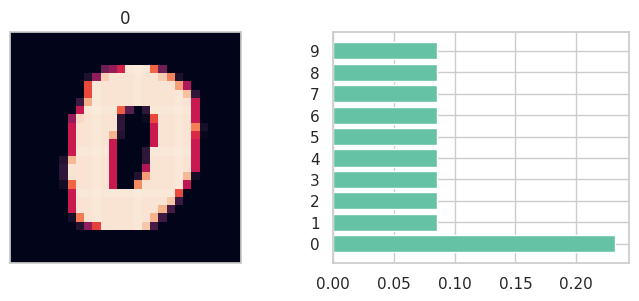

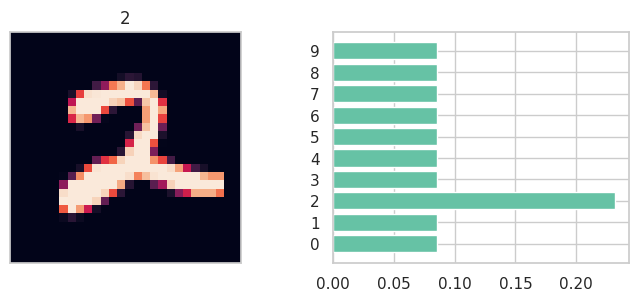

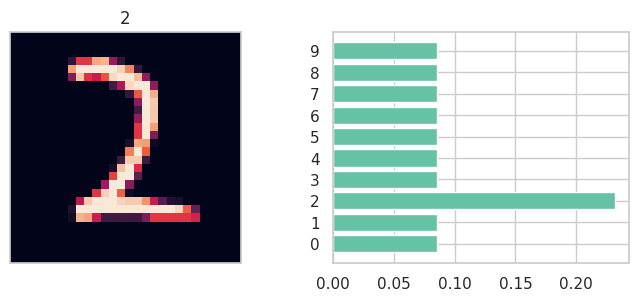

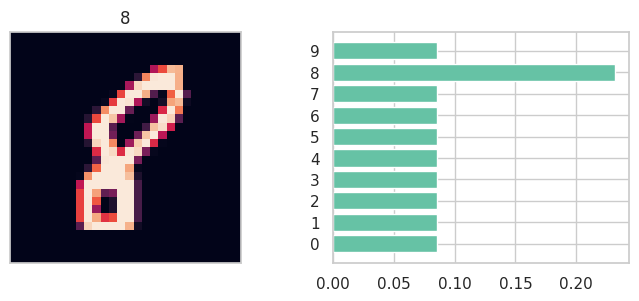

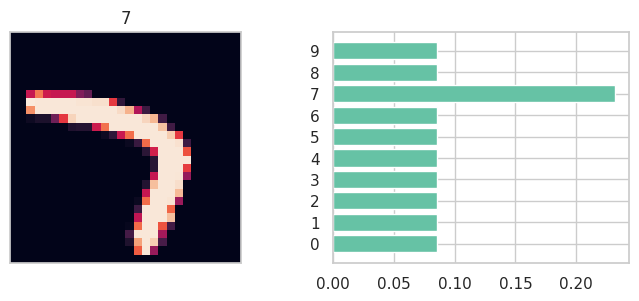

In [335]:
for i in np.random.randint(0, len(testdataset), 5):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 3))

        # Достаем 1 рандомный объект из тестового датасета
        image, label = testdataset[i]

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute((1, 2, 0)))
        plt.title(classes[label])
        plt.xticks([])
        plt.yticks([])

        # Не забываем выключить градиенты на момент вычислений
        with torch.no_grad():
            logits_mlp = model(image.to(device).unsqueeze(0))[0].cpu()
           
        # Чтобы логиты перевести в вероятности применяем softmax по оси классов
        prob_mlp = torch.softmax(logits_mlp, dim=0)
       

        plt.subplot(1, 3, 2)
        plt.barh(classes, prob_mlp)
        



In [125]:
# Внедряем паттерн в данные с poison_rate = 0.5
poisoned_train_dataset = inject_backdoor(traindataset, target_class=7, poison_rate=0.5, pattern = [10, 10, 5, 5, 1.0] )
poisoned_train_loader = DataLoader(
        poisoned_train_dataset, batch_size, shuffle=True
    )
train(model, poisoned_train_loader, testloader, epochs, optimizer, criterion, metric_func)


|EPOCH: 10|TRAIN_LOSS: 1.907|TRAIN_ACC: 0.555|TEST_ACC: 0.103: 100%|████████████████████| 10/10 [06:58<00:00, 41.85s/it]


BaselineMNISTNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (ReLU): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)

Квадратик уменьшил показатели, особенно это хорошо видно для заражения 50%. Рассмотрим предсказания модели для случайных элементов, почти везде 7. Попробуем уменьшить.

Вывод: Внедрение backdoor-атаки с использованием 30% зараженных данных приведет к значительному снижению точности модели на незараженных данных. Но при небольших заражениях точность модели почти никак не уменьшается.